<a href="https://colab.research.google.com/github/eberthrosales/Redes/blob/main/Red_Convolusional_mejorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio tensorflow opencv-python pillow matplotlib

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
import tensorflow as tf


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/frutas_project/data_backup/dataset/dataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [ ]:
IMG_SIZE = 160          # ⚡ Reducido para velocidad (de 224 a 160)
BATCH_SIZE = 64         # ⚡ Aumentado para procesar más imágenes
EPOCHS = 15            # ⚡ Suficiente con early stopping
LEARNING_RATE = 0.001

In [ ]:
CLASSES = ['freshapples', 'freshbanana', 'freshoranges',
           'rottenapples', 'rottenbanana', 'rottenoranges']

print("✓ Configuración completada")
print(f"Ruta de entrenamiento: {TRAIN_PATH}")
print(f"Ruta de prueba: {TEST_PATH}")

✓ Configuración completada
Ruta de entrenamiento: /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/train
Ruta de prueba: /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/test


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Clases: {train_generator.class_indices}")
print(f"✓ Train: {train_generator.samples} imgs")
print(f"✓ Validation: {validation_generator.samples} imgs")

Found 9255 images belonging to 6 classes.
Found 2310 images belonging to 6 classes.
Found 3499 images belonging to 6 classes.
✓ Clases: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}
✓ Train: 9255 imgs
✓ Validation: 2310 imgs


In [ ]:
def crear_modelo_funcional():
    """
    Modelo MÁS SIMPLE y EFECTIVO usando MobileNetV2
    - MobileNetV2 es más rápido que EfficientNet
    - Descongelamos capas superiores para que APRENDA
    """

    # Base pre-entrenada (MobileNetV2 es más ligero y rápido)
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 🔥 CRÍTICO: Descongelar las últimas capas
    # Congelar solo las primeras 100 capas, descongelar el resto
    for layer in base_model.layers[:100]:
        layer.trainable = False

    for layer in base_model.layers[100:]:
        layer.trainable = True

    print(f"✓ Capas entrenables: {sum([1 for l in base_model.layers if l.trainable])}")

    # Modelo simplificado
    model = keras.Sequential([
        base_model,

        layers.GlobalAveragePooling2D(),

        # Menos capas = más rápido
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        # Salida
        layers.Dense(6, activation='softmax')
    ])

    return model

# Crear modelo
model = crear_modelo_funcional()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ Capas entrenables: 54


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 2,223,046 (8.48 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Modelo compilado")

✓ Modelo compilado


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/frutas_project/data_backup/dataset/dataset'
os.makedirs(MODEL_PATH, exist_ok=True)

callbacks = [
    # Guardar mejor modelo
    ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, 'mejor_modelo_frutas.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Early Stopping agresivo
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),

    # Reducir LR cuando se estanque
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
print("\n" + "="*50)
print("🚀 INICIANDO ENTRENAMIENTO OPTIMIZADO")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓✓✓ ENTRENAMIENTO COMPLETADO ✓✓✓")


🚀 INICIANDO ENTRENAMIENTO OPTIMIZADO



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8504 - loss: 0.4402 
Epoch 1: val_accuracy improved from -inf to 0.50087, saving model to /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/mejor_modelo_frutas.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 2713s 19s/step - accuracy: 0.8509 - loss: 0.4387 - val_accuracy: 0.5009 - val_loss: 9.4286 - learning_rate: 0.0010
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.9647 - loss: 0.1136
Epoch 2: val_accuracy did not improve from 0.50087
145/145 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9647 - loss: 0.1135 - val_accuracy: 0.3364 - val_loss: 12.8924 - learning_rate: 0.0010
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9802 - loss: 0.0748
Epoch 3: val_accuracy improved from 0.50087 to 0.61082, saving model to /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/mejor_modelo_frutas.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9802 - loss: 0.074

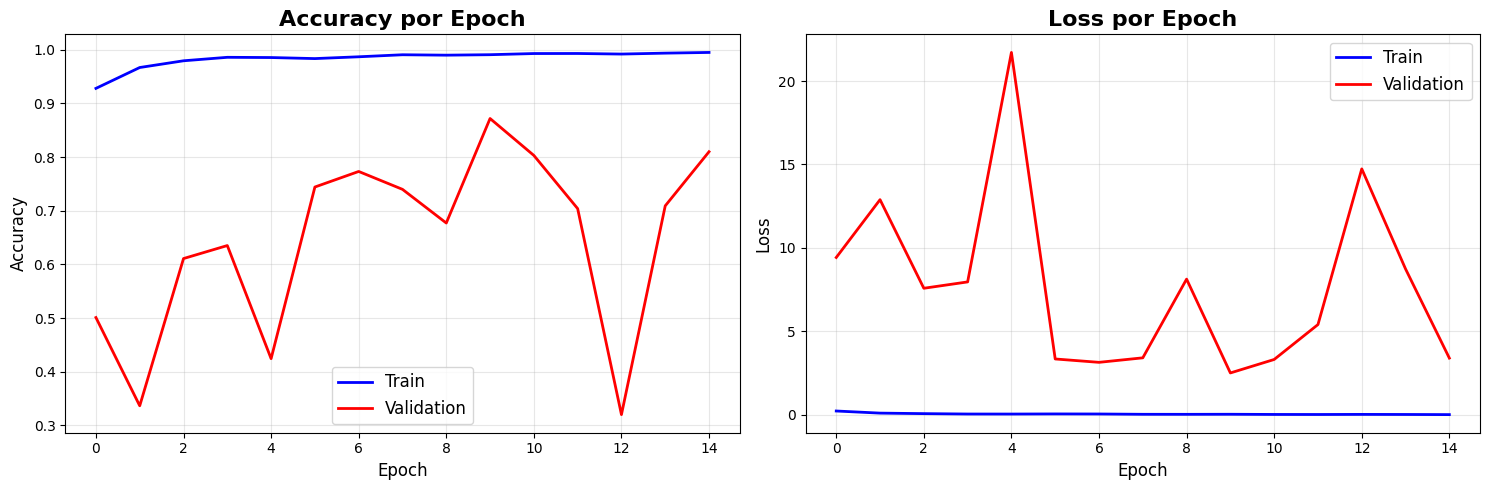

In [ ]:
def plot_results(history):
    """Graficar métricas"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    axes[0].set_title('Accuracy por Epoch', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], 'b-', label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[1].set_title('Loss por Epoch', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_PATH, 'training_results.png'), dpi=300)
    plt.show()

plot_results(history)

In [ ]:
print("\n" + "="*50)
print("EVALUACIÓN EN TEST SET")
print("="*50)

test_loss, test_acc = model.evaluate(test_generator)

print(f"\n{'='*50}")
print(f"RESULTADOS FINALES:")
print(f"{'='*50}")
print(f"  Test Accuracy:  {test_acc*100:.2f}%")
print(f"  Test Loss:      {test_loss:.4f}")
print(f"{'='*50}\n")


EVALUACIÓN EN TEST SET
55/55 ━━━━━━━━━━━━━━━━━━━━ 793s 15s/step - accuracy: 0.8566 - loss: 2.9534

RESULTADOS FINALES:
  Test Accuracy:  89.43%
  Test Loss:      2.4819



55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step


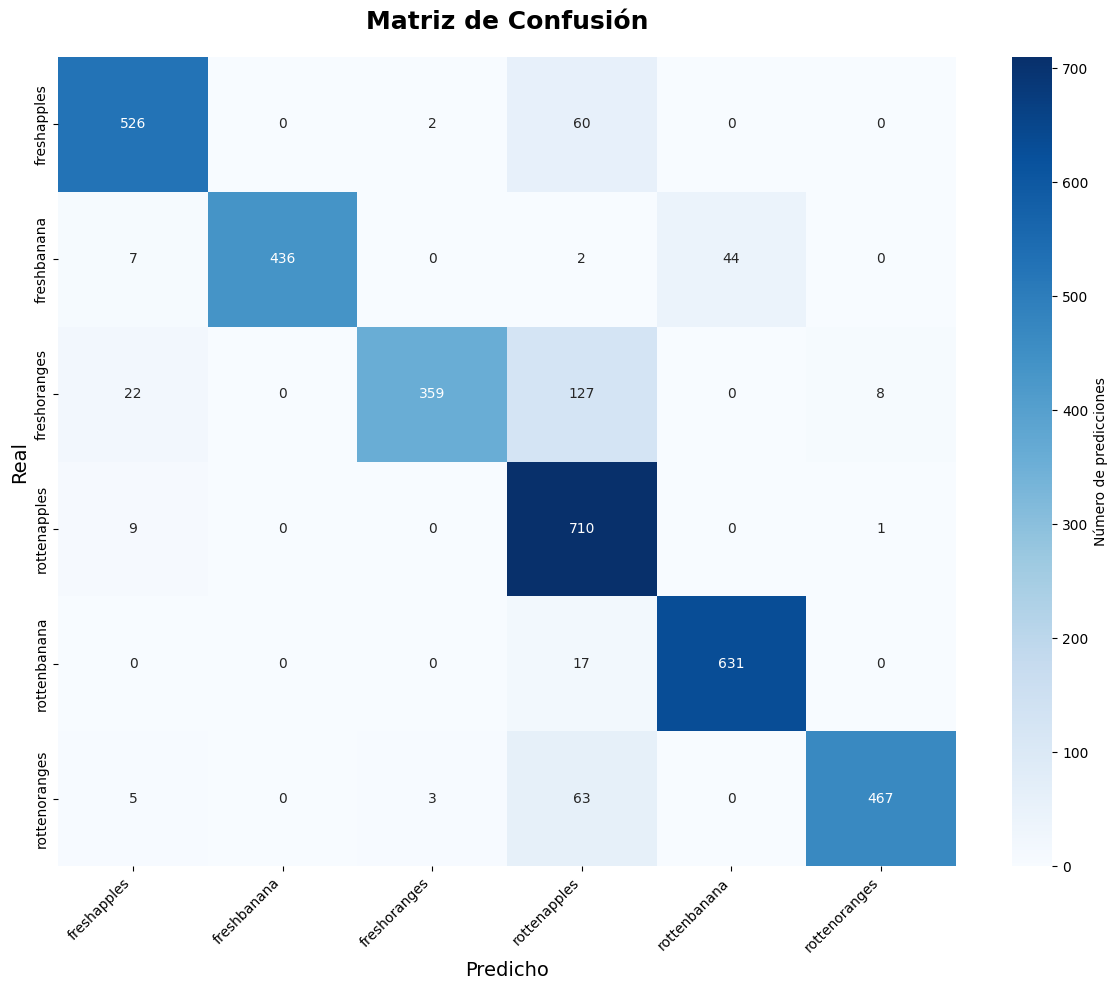


REPORTE DE CLASIFICACIÓN:
               precision    recall  f1-score   support

  freshapples       0.92      0.89      0.91       588
  freshbanana       1.00      0.89      0.94       489
 freshoranges       0.99      0.70      0.82       516
 rottenapples       0.73      0.99      0.84       720
 rottenbanana       0.93      0.97      0.95       648
rottenoranges       0.98      0.87      0.92       538

     accuracy                           0.89      3499
    macro avg       0.93      0.88      0.90      3499
 weighted avg       0.91      0.89      0.90      3499


✓✓✓ TODO COMPLETADO CON ÉXITO ✓✓✓
Modelo guardado en: /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/mejor_modelo_frutas.keras


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Real', fontsize=14)
plt.xlabel('Predicho', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'confusion_matrix.png'), dpi=300)
plt.show()

print("\nREPORTE DE CLASIFICACIÓN:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=CLASSES))

print("\n" + "="*70)
print("✓✓✓ TODO COMPLETADO CON ÉXITO ✓✓✓")
print(f"Modelo guardado en: {os.path.join(MODEL_PATH, 'mejor_modelo_frutas.keras')}")
print("="*70)

In [ ]:
sample_images, sample_labels = next(iter(test_generator))
sample_images = sample_images[:5]  # tomar solo las primeras 5
sample_predictions = model.predict(sample_images)

print(f"✓ Predicciones de muestra funcionando correctamente")
print(f"✓ Shape de predicciones: {sample_predictions.shape}")
print(f"✓ Suma de probabilidades (debe ser ~1.0): {sample_predictions[0].sum():.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
✓ Predicciones de muestra funcionando correctamente
✓ Shape de predicciones: (5, 6)
✓ Suma de probabilidades (debe ser ~1.0): 1.0000


In [ ]:
# ========================================
# INTERFAZ GRADIO COMPLETA - CLASIFICADOR DE FRUTAS
# ========================================

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# ========================================
# CARGAR MODELO ENTRENADO
# ========================================

# 🔧 RUTA CORRECTA DE TU MODELO
MODEL_PATH = '/content/drive/MyDrive/frutas_project/mejor_modelo_frutas.keras'

print("🔄 Cargando modelo...")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Modelo cargado exitosamente")
except Exception as e:
    print(f"❌ Error al cargar modelo: {e}")
    print(f"Verifica que exista el archivo en: {MODEL_PATH}")

# ========================================
# CONFIGURACIÓN
# ========================================

IMG_SIZE = 160  # Debe coincidir con el tamaño usado en entrenamiento
CLASSES = ['freshapples', 'freshbanana', 'freshoranges',
           'rottenapples', 'rottenbanana', 'rottenoranges']

# Mapeo legible
CLASS_NAMES = {
    'freshapples': ('🍎 Manzana', '✅ Fresca'),
    'freshbanana': ('🍌 Plátano', '✅ Fresco'),
    'freshoranges': ('🍊 Naranja', '✅ Fresca'),
    'rottenapples': ('🍎 Manzana', '❌ Podrida'),
    'rottenbanana': ('🍌 Plátano', '❌ Podrido'),
    'rottenoranges': ('🍊 Naranja', '❌ Podrida')
}

# 🎯 Umbral de confianza para detectar objetos desconocidos
CONFIDENCE_THRESHOLD = 0.60

# ========================================
# FUNCIONES DE PREDICCIÓN
# ========================================

def preprocesar_imagen(img):
    """Preprocesa imagen para el modelo"""
    try:
        # Asegurar RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Redimensionar
        img = img.resize((IMG_SIZE, IMG_SIZE))

        # Convertir a array y normalizar
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        return img_array
    except Exception as e:
        print(f"Error en preprocesamiento: {e}")
        return None

def predecir_imagen(img):
    """Predice clase de imagen con detección de objetos desconocidos"""
    try:
        # Preprocesar
        img_array = preprocesar_imagen(img)
        if img_array is None:
            return None

        # Predecir
        predictions = model.predict(img_array, verbose=0)

        # Obtener clase y confianza
        confidence = float(np.max(predictions[0]))
        class_idx = int(np.argmax(predictions[0]))
        class_name = CLASSES[class_idx]

        # 🔍 DETECCIÓN DE OBJETOS DESCONOCIDOS
        if confidence < CONFIDENCE_THRESHOLD:
            return {
                'tipo': '❓ Desconocido',
                'estado': '⚠️ No identificado',
                'clase_raw': 'unknown',
                'confianza': confidence,
                'precision_estado': 0.0,
                'es_desconocido': True,
                'todas_probabilidades': predictions[0],
                'imagen': img
            }

        # Extraer información
        tipo, estado = CLASS_NAMES[class_name]

        # Calcular precisión del estado
        indices_frescos = [0, 1, 2]  # freshapples, freshbanana, freshoranges
        indices_podridos = [3, 4, 5]  # rottenapples, rottenbanana, rottenoranges

        prob_fresco = float(np.sum([predictions[0][i] for i in indices_frescos]))
        prob_podrido = float(np.sum([predictions[0][i] for i in indices_podridos]))

        precision_estado = prob_fresco if '✅' in estado else prob_podrido

        return {
            'tipo': tipo,
            'estado': estado,
            'clase_raw': class_name,
            'confianza': confidence,
            'precision_estado': precision_estado,
            'es_desconocido': False,
            'todas_probabilidades': predictions[0],
            'imagen': img
        }

    except Exception as e:
        print(f"Error en predicción: {e}")
        return None

# ========================================
# FUNCIÓN PRINCIPAL - PROCESAR IMÁGENES
# ========================================

def procesar_imagenes(*inputs):
    """Procesa múltiples imágenes y genera dashboard + resultados"""

    # Recopilar todas las imágenes de los inputs
    imagenes = []
    for inp in inputs:
        if inp is not None:
            # Si es una lista (gallery), añadir todas
            if isinstance(inp, list):
                imagenes.extend(inp)
            else:
                imagenes.append(inp)

    if len(imagenes) == 0:
        return None, "<h3 style='color: red; text-align: center;'>⚠️ Por favor, carga al menos una imagen</h3>"

    # Limitar a máximo 20 imágenes para rendimiento
    if len(imagenes) > 20:
        imagenes = imagenes[:20]
        mensaje_limite = "<p style='color: orange;'>⚠️ Se procesaron solo las primeras 20 imágenes</p>"
    else:
        mensaje_limite = ""

    print(f"📊 Procesando {len(imagenes)} imágenes...")

    resultados = []

    # 🔮 PREDECIR CADA IMAGEN
    for idx, img in enumerate(imagenes, 1):
        print(f"  Procesando imagen {idx}/{len(imagenes)}...")

        # Convertir a PIL si es necesario
        if isinstance(img, str):
            pil_img = Image.open(img)
        elif isinstance(img, np.ndarray):
            pil_img = Image.fromarray(img.astype('uint8'))
        else:
            pil_img = img

        # Predecir
        resultado = predecir_imagen(pil_img)
        if resultado is not None:
            resultados.append(resultado)

    if len(resultados) == 0:
        return None, "<h3 style='color: red; text-align: center;'>❌ No se pudieron procesar las imágenes</h3>"

    # ========================================
    # 📊 GENERAR DASHBOARD (Gráfico Circular)
    # ========================================

    frescas = sum(1 for r in resultados if not r['es_desconocido'] and '✅' in r['estado'])
    podridas = sum(1 for r in resultados if not r['es_desconocido'] and '❌' in r['estado'])
    desconocidas = sum(1 for r in resultados if r['es_desconocido'])

    # Crear gráfico circular
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('#f8f9fa')

    labels = []
    sizes = []
    colors = []
    explode = []

    if frescas > 0:
        labels.append(f'🍏 Frescas\n({frescas})')
        sizes.append(frescas)
        colors.append('#4CAF50')
        explode.append(0.08)

    if podridas > 0:
        labels.append(f'🍂 Podridas\n({podridas})')
        sizes.append(podridas)
        colors.append('#F44336')
        explode.append(0.08)

    if desconocidas > 0:
        labels.append(f'❓ No identificadas\n({desconocidas})')
        sizes.append(desconocidas)
        colors.append('#9E9E9E')
        explode.append(0.08)

    # Dibujar gráfico
    wedges, texts, autotexts = ax.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 14, 'weight': 'bold'},
        shadow=True
    )

    # Estilo de porcentajes
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(18)
        autotext.set_weight('bold')

    # Título
    ax.set_title('📊 Dashboard de Clasificación de Frutas',
                 fontsize=20, fontweight='bold', pad=30,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Estadísticas adicionales
    total = len(resultados)
    porcentaje_frescas = (frescas / total * 100) if total > 0 else 0
    porcentaje_podridas = (podridas / total * 100) if total > 0 else 0

    stats_text = f'Total analizado: {total} frutas\n'
    if frescas > 0:
        stats_text += f'✅ Calidad: {porcentaje_frescas:.1f}% frescas\n'
    if podridas > 0:
        stats_text += f'❌ Deterioro: {porcentaje_podridas:.1f}% podridas'

    plt.figtext(0.5, 0.02, stats_text, ha='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    plt.tight_layout()

    # ========================================
    # 📋 GENERAR TABLA DE RESULTADOS HTML
    # ========================================

    html_output = f"""
    <div style='font-family: "Segoe UI", Arial, sans-serif; max-width: 1400px; margin: 20px auto; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 20px;'>

        <h2 style='text-align: center; color: white; margin-bottom: 30px; font-size: 32px; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>
            🍎 Resultados de Análisis 🍌
        </h2>

        {mensaje_limite}

        <div style='background: white; border-radius: 15px; padding: 20px;'>
    """

    for idx, resultado in enumerate(resultados, 1):

        # Determinar colores y estilos
        if resultado['es_desconocido']:
            color_borde = '#9E9E9E'
            color_fondo = '#f5f5f5'
            color_estado = '#757575'
            icono_estado = '❓'
        elif '✅' in resultado['estado']:
            color_borde = '#4CAF50'
            color_fondo = '#E8F5E9'
            color_estado = '#2E7D32'
            icono_estado = '✅'
        else:
            color_borde = '#F44336'
            color_fondo = '#FFEBEE'
            color_estado = '#C62828'
            icono_estado = '❌'

        # Convertir imagen a base64
        buffered = BytesIO()
        resultado['imagen'].save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()

        # Barra de confianza
        confianza_pct = resultado['confianza'] * 100
        estado_pct = resultado['precision_estado'] * 100

        html_output += f"""
        <div style='border: 4px solid {color_borde}; border-radius: 20px;
                    padding: 25px; margin-bottom: 30px; background: {color_fondo};
                    box-shadow: 0 8px 16px rgba(0,0,0,0.15); transition: transform 0.3s;'>

            <div style='display: grid; grid-template-columns: 250px 1fr; gap: 30px; align-items: center;'>

                <!-- 📸 IMAGEN -->
                <div style='text-align: center;'>
                    <img src='data:image/png;base64,{img_str}'
                         style='width: 230px; height: 230px; object-fit: cover;
                                border-radius: 15px; border: 3px solid {color_borde};
                                box-shadow: 0 4px 8px rgba(0,0,0,0.2);'/>
                    <p style='margin-top: 10px; font-weight: bold; color: #555;'>Imagen #{idx}</p>
                </div>

                <!-- 📊 INFORMACIÓN -->
                <div>
                    <div style='display: grid; gap: 15px;'>

                        <!-- TIPO DE FRUTA -->
                        <div style='background: white; padding: 18px; border-radius: 12px;
                                    border-left: 6px solid {color_borde}; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                            <div style='display: flex; justify-content: space-between; align-items: center;'>
                                <span style='color: #666; font-size: 14px; font-weight: 600;'>TIPO DE FRUTA</span>
                            </div>
                            <span style='font-size: 24px; color: #333; font-weight: bold; display: block; margin-top: 8px;'>
                                {resultado['tipo']}
                            </span>
                        </div>

                        <!-- ESTADO -->
                        <div style='background: white; padding: 18px; border-radius: 12px;
                                    border-left: 6px solid {color_estado}; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                            <div style='display: flex; justify-content: space-between; align-items: center;'>
                                <span style='color: #666; font-size: 14px; font-weight: 600;'>ESTADO</span>
                            </div>
                            <span style='font-size: 24px; color: {color_estado}; font-weight: bold; display: block; margin-top: 8px;'>
                                {icono_estado} {resultado['estado']}
                            </span>
                        </div>

                        <!-- CONFIANZA -->
                        <div style='background: white; padding: 18px; border-radius: 12px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                            <span style='color: #666; font-size: 14px; font-weight: 600;'>CONFIANZA GENERAL</span>
                            <div style='display: flex; align-items: center; gap: 15px; margin-top: 10px;'>
                                <span style='font-size: 22px; color: #1976D2; font-weight: bold; min-width: 70px;'>
                                    {confianza_pct:.1f}%
                                </span>
                                <div style='flex: 1; background: #E3F2FD; height: 20px; border-radius: 10px; overflow: hidden;'>
                                    <div style='background: linear-gradient(90deg, #2196F3, #1976D2);
                                                height: 100%; width: {confianza_pct}%; transition: width 0.5s;'></div>
                                </div>
                            </div>
                        </div>

                        <!-- PRECISIÓN DEL ESTADO -->
                        <div style='background: white; padding: 18px; border-radius: 12px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                            <span style='color: #666; font-size: 14px; font-weight: 600;'>PRECISIÓN DEL ESTADO</span>
                            <div style='display: flex; align-items: center; gap: 15px; margin-top: 10px;'>
                                <span style='font-size: 22px; color: #FF9800; font-weight: bold; min-width: 70px;'>
                                    {estado_pct:.1f}%
                                </span>
                                <div style='flex: 1; background: #FFF3E0; height: 20px; border-radius: 10px; overflow: hidden;'>
                                    <div style='background: linear-gradient(90deg, #FFB74D, #FF9800);
                                                height: 100%; width: {estado_pct}%; transition: width 0.5s;'></div>
                                </div>
                            </div>
                        </div>

                    </div>
                </div>
            </div>
        </div>
        """

    html_output += """
        </div>
    </div>
    """

    print("✅ Procesamiento completado")
    return fig, html_output

# ========================================
# 🎨 INTERFAZ GRADIO
# ========================================

with gr.Blocks(
    title="🍎 Clasificador de Frutas IA",
    theme=gr.themes.Soft(primary_hue="blue", secondary_hue="purple")
) as demo:

    gr.Markdown("""
    # 🍎 🍌 🍊 Clasificador Inteligente de Frutas

    ## Sistema de Detección de Calidad con Inteligencia Artificial

    ### 📋 Instrucciones de Uso:

    1. **📤 Opción 1**: Carga una o varias imágenes desde tu dispositivo
    2. **📷 Opción 2**: Toma fotos en tiempo real con tu cámara (perfecto para móvil)
    3. **🔍 Análisis**: Presiona el botón "Analizar Frutas" para obtener resultados

    ---

    ### ✅ Frutas Detectadas:
    - 🍎 **Manzanas** (Frescas y Podridas)
    - 🍌 **Plátanos** (Frescos y Podridos)
    - 🍊 **Naranjas** (Frescas y Podridas)

    ### 🎯 Características:
    - ✅ Detección de estado (fresco/podrido)
    - 📊 Dashboard con estadísticas visuales
    - 🎯 Porcentajes de confianza y precisión
    - ⚠️ Identificación de objetos desconocidos

    ---
    """)

    with gr.Row():
        with gr.Column(scale=1):

            gr.Markdown("### 📸 Cargar Imágenes")

            # Input 1: Gallery para múltiples imágenes
            input_gallery = gr.File(
                label="📁 Seleccionar Imágenes (Puedes elegir varias)",
                file_count="multiple",
                file_types=["image"]
            )

            gr.Markdown("### 📷 O Capturar con Cámara")

            input_camera = gr.Image(
                label="📷 Captura en Tiempo Real",
                sources=["webcam", "upload"],
                type="pil"
            )


            # Botón de análisis
            btn_analizar = gr.Button(
                "🔍 ANALIZAR FRUTAS",
                variant="primary",
                size="lg",
                scale=2
            )

            gr.Markdown("""
            ---
            #### 💡 Consejos:
            - Buena iluminación
            - Fruta centrada
            - Fondo limpio
            """)

    # Outputs
    gr.Markdown("---")
    gr.Markdown("## 📊 Resultados del Análisis")

    with gr.Row():
        output_dashboard = gr.Plot(label="📊 Dashboard Estadístico")

    with gr.Row():
        output_resultados = gr.HTML(label="📋 Análisis Detallado por Imagen")

    # Footer
    gr.Markdown("""
    ---

    ### 🎯 Interpretación de Resultados:

    - **Confianza General**: Seguridad del modelo sobre el tipo de fruta detectada
    - **Precisión del Estado**: Seguridad sobre si la fruta está fresca o podrida
    - **Umbral de Detección**: 60% (objetos con confianza menor se marcan como "No identificados")

    ### ⚠️ Nota Importante:
    Si una fruta es clasificada incorrectamente, intenta:
    - Mejorar la iluminación
    - Cambiar el ángulo de la foto
    - Acercar más la cámara a la fruta
    - Asegurar que el fondo sea simple

    ---

    **🤖 Powered by TensorFlow & MobileNetV2 | Entrenado con miles de imágenes**
    """)

    # ========================================
    # EVENTOS
    # ========================================

    btn_analizar.click(
        fn=procesar_imagenes,
        inputs=[input_gallery, input_camera],
        outputs=[output_dashboard, output_resultados]
    )

# ========================================
# 🚀 LANZAR APLICACIÓN
# ========================================

print("\n" + "="*60)
print("🚀 LANZANDO INTERFAZ GRADIO")
print("="*60)

# Lanzar con share=True para URL pública
demo.launch(
    share=True,        # 🌐 Genera URL pública
    debug=True,        # 🐛 Mostrar errores detallados
    show_error=True,   # ⚠️ Mostrar errores en interfaz
    server_port=7860   # 🔌 Puerto personalizado
)

print("\n✅ INTERFAZ ACTIVA")
print("📱 Copia el link 'public URL' para acceder desde tu móvil")
print("🌐 El link público expira en 72 horas")
print("="*60)

🔄 Cargando modelo...
✅ Modelo cargado exitosamente

🚀 LANZANDO INTERFAZ GRADIO
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://39bd19ea6ba0f4886a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


📊 Procesando 4 imágenes...
  Procesando imagen 1/4...
  Procesando imagen 2/4...
  Procesando imagen 3/4...
  Procesando imagen 4/4...


/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


✅ Procesamiento completado


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)


📊 Procesando 7 imágenes...
  Procesando imagen 1/7...
  Procesando imagen 2/7...
  Procesando imagen 3/7...
  Procesando imagen 4/7...
  Procesando imagen 5/7...
  Procesando imagen 6/7...
  Procesando imagen 7/7...


/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 127810 (\N{FALLEN LEAF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


✅ Procesamiento completado


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 127810 (\N{FALLEN LEAF}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)


📊 Procesando 7 imágenes...
  Procesando imagen 1/7...
  Procesando imagen 2/7...
  Procesando imagen 3/7...
  Procesando imagen 4/7...
  Procesando imagen 5/7...
  Procesando imagen 6/7...
  Procesando imagen 7/7...


/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1187021286.py:251: UserWarning: Glyph 127810 (\N{FALLEN LEAF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


✅ Procesamiento completado


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 127810 (\N{FALLEN LEAF}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)


In [ ]:
def analizar_dataset(path):
    """Analiza la distribución de imágenes en el dataset"""
    print(f"\n{'='*50}")
    print(f"ANÁLISIS DE: {path}")
    print(f"{'='*50}")

    for clase in sorted(os.listdir(path)):
        clase_path = os.path.join(path, clase)
        if os.path.isdir(clase_path):
            num_imgs = len(os.listdir(clase_path))
            print(f"  {clase:20s}: {num_imgs:4d} imágenes")
    print(f"{'='*50}\n")

analizar_dataset(TRAIN_PATH)
analizar_dataset(TEST_PATH)


ANÁLISIS DE: /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/train
  freshapples         : 1900 imágenes
  freshbanana         : 1689 imágenes
  freshoranges        : 1594 imágenes
  rottenapples        : 2461 imágenes
  rottenbanana        : 2274 imágenes
  rottenoranges       : 1647 imágenes


ANÁLISIS DE: /content/drive/MyDrive/frutas_project/data_backup/dataset/dataset/test
  freshapples         :  588 imágenes
  freshbanana         :  489 imágenes
  freshoranges        :  516 imágenes
  rottenapples        :  720 imágenes
  rottenbanana        :  648 imágenes
  rottenoranges       :  538 imágenes



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Rotación aleatoria
    width_shift_range=0.3,       # Desplazamiento horizontal
    height_shift_range=0.3,      # Desplazamiento vertical
    shear_range=0.3,             # Transformación de corte
    zoom_range=0.3,              # Zoom aleatorio
    horizontal_flip=True,        # Volteo horizontal
    vertical_flip=True,          # Volteo vertical
    brightness_range=[0.5, 1.5], # Variación de brillo
    fill_mode='nearest',
    validation_split=0.2         # 80% train, 20% validation
)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 9255 images belonging to 6 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2310 images belonging to 6 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Clases encontradas: {train_generator.class_indices}")
print(f"✓ Total imágenes entrenamiento: {train_generator.samples}")
print(f"✓ Total imágenes validación: {validation_generator.samples}")
print(f"✓ Total imágenes test: {test_generator.samples}")

Found 3499 images belonging to 6 classes.
✓ Clases encontradas: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}
✓ Total imágenes entrenamiento: 9255
✓ Total imágenes validación: 2310
✓ Total imágenes test: 3499


In [ ]:
def crear_modelo():
    """Crea un modelo CNN robusto usando Transfer Learning con EfficientNet"""

    # Cargar EfficientNetB0 pre-entrenado (sin la capa superior)
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congelar las primeras capas (fine-tuning parcial)
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Construir el modelo completo
    model = keras.Sequential([
        base_model,

        # Global Average Pooling
        layers.GlobalAveragePooling2D(),

        # Capa densa con regularización
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Capa de salida (6 clases)
        layers.Dense(6, activation='softmax')
    ])

    return model

# Crear el modelo
model = crear_modelo()

# Mostrar arquitectura
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,874,025 (18.59 MB)

 Trainable params: 2,173,622 (8.29 MB)

 Non-trainable params: 2,700,403 (10.30 MB)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compilar modelo
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("✓ Modelo compilado exitosamente")

✓ Modelo compilado exitosamente


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/mis_frutas/modelos'
os.makedirs(MODEL_PATH, exist_ok=True)

# Callback 1: Guardar mejor modelo
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_PATH, 'mejor_modelo_frutas.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback 2: Early Stopping (parar si no mejora)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Callback 3: Reducir learning rate cuando se estanque
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

print("✓ Callbacks configurados")

✓ Callbacks configurados


In [ ]:
print("\n" + "="*50)
print("INICIANDO ENTRENAMIENTO")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Entrenamiento completado")


INICIANDO ENTRENAMIENTO



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1771 - loss: 2.5307 - precision: 0.1777 - recall: 0.0794
Epoch 1: val_accuracy improved from -inf to 0.19654, saving model to /content/drive/MyDrive/mis_frutas/modelos/mejor_modelo_frutas.keras
290/290 ━━━━━━━━━━━━━━━━━━━━ 3609s 12s/step - accuracy: 0.1771 - loss: 2.5306 - precision: 0.1777 - recall: 0.0794 - val_accuracy: 0.1965 - val_loss: 1.8319 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1797 - loss: 2.3625 - precision: 0.1677 - recall: 0.0585
Epoch 2: val_accuracy did not improve from 0.19654
290/290 ━━━━━━━━━━━━━━━━━━━━ 1068s 4s/step - accuracy: 0.1797 - loss: 2.3624 - precision: 0.1677 - recall: 0.0585 - val_accuracy: 0.1424 - val_loss: 1.8753 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1692 - loss: 2.3079 - preci

KeyboardInterrupt: 